In [36]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import bokeh.io
import bokeh.plotting
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from tdc.multi_pred import PPI
from tqdm import tqdm

ts = time.time()
bokeh.io.output_notebook()

KeyboardInterrupt: 

In [21]:
data = PPI(name = 'HuRI')
data = data.neg_sample(frac = 1)
split = data.get_split()
train = split['train']
valid = split['valid']
test = split['test']

Found local copy...
Loading...
Done!


In [22]:
# remove data where protein sequences are longer than 800 amino acids
train = train.loc[train["Protein1"].str.len()<800]
train = train.loc[train["Protein2"].str.len()<800]
valid = valid.loc[valid["Protein1"].str.len()<800]
valid = valid.loc[valid["Protein2"].str.len()<800]
test = test.loc[test["Protein1"].str.len()<800]
test = test.loc[test["Protein2"].str.len()<800]

In [23]:
train.head(2)

,Protein1_ID,Protein1,Protein2_ID,Protein2,Y
0,ENSG00000000005,MAKNPPENCEDCHILNAEAFKSKKICKSLKICGLVFGILALTLIVL...,ENSG00000061656,MRRSSRPGSASSSRKHTPNFFSENSSMSITSEDSKGLRSAEPGPGE...,1
1,ENSG00000000005,MAKNPPENCEDCHILNAEAFKSKKICKSLKICGLVFGILALTLIVL...,ENSG00000104765,MSSHLVEPPPPLHNNNNNCEENEQSLPPPAGLNSSWVELPMNSSNG...,1


In [24]:
aatoidx = {}
i = 1
skip = False
for p1 in train['Protein1']:
    for c1 in p1:
        if c1 not in aatoidx.keys():
            aatoidx[c1] = i
            i += 1
    if i == 24:
        skip = True
        break
if not skip:
    for p2 in train['Protein2']:
        for c2 in p2:
            if c1 not in aatoidx.keys():
                aatoidx[c1] = i
                i += 1
        if i == 23:
            break

idxtoaa = {}
for key in aatoidx.keys():
    idxtoaa[aatoidx[key]] = key

In [25]:
aa1 = [[aatoidx[s[i]] if i < len(s) else 0 for i in range(800)] for s in train['Protein1']]
aa2 = [[aatoidx[s[i]] if i < len(s) else 0 for i in range(800)] for s in train['Protein2']]
aav1 = [[aatoidx[s[i]] if i < len(s) else 0 for i in range(800)] for s in valid['Protein1']]
aav2 = [[aatoidx[s[i]] if i < len(s) else 0 for i in range(800)] for s in valid['Protein2']]
aat1 = [[aatoidx[s[i]] if i < len(s) else 0 for i in range(800)] for s in test['Protein1']]
aat2 = [[aatoidx[s[i]] if i < len(s) else 0 for i in range(800)] for s in test['Protein2']]

In [26]:
len(aa1), len(aa2), len(aav1), len(aav2), len(aat1), len(aat2)

(18386, 18386, 2549, 2549, 5272, 5272)

In [27]:
print('Min protein lengths:')
print('\tTrain 1:', min([len(s) for s in aa1]))
print('\tTrain 2:', min([len(s) for s in aa2]))
print('\tValid 1:', min([len(s) for s in aav1]))
print('\tValid 2:', min([len(s) for s in aav2]))
print('\tTest 1:', min([len(s) for s in aat1]))
print('\tTest 2:', min([len(s) for s in aat2]))
print('Mean protein lengths:')
print('\tTrain 1:', sum([len(s) for s in aa1])/len(aa1))
print('\tTrain 2:', sum([len(s) for s in aa2])/len(aa2))
print('\tValid 1:', sum([len(s) for s in aav1])/len(aav1))
print('\tValid 2:', sum([len(s) for s in aav2])/len(aav2))
print('\tTest 1:', sum([len(s) for s in aat1])/len(aat1))
print('\tTest 2:', sum([len(s) for s in aat2])/len(aat2))
print('Max protein lengths:')
print('\tTrain 1:', max([len(s) for s in aa1]))
print('\tTrain 2:', max([len(s) for s in aa2]))
print('\tValid 1:', max([len(s) for s in aav1]))
print('\tValid 2:', max([len(s) for s in aav2]))
print('\tTest 1:', max([len(s) for s in aat1]))
print('\tTest 2:', max([len(s) for s in aat2]))

Min protein lengths:
	Train 1: 800
	Train 2: 800
	Valid 1: 800
	Valid 2: 800
	Test 1: 800
	Test 2: 800
Mean protein lengths:
	Train 1: 800.0
	Train 2: 800.0
	Valid 1: 800.0
	Valid 2: 800.0
	Test 1: 800.0
	Test 2: 800.0
Max protein lengths:
	Train 1: 800
	Train 2: 800
	Valid 1: 800
	Valid 2: 800
	Test 1: 800
	Test 2: 800


In [28]:
# p = bokeh.plotting.figure(title='Sequence Length CDFs', x_axis_type='log', y_axis_type='log')
# p.line(lens, [(i+1)/len(aa1) for i in range(len(aa1))],
#        color='red', legend_label='Train 1', line_width=3, alpha=0.5)
# p.line(lens2, [(i+1)/len(aa2) for i in range(len(aa2))],
#        color='orange', legend_label='Train 2', line_width=3, alpha=0.5)
# p.line(lensv, [(i+1)/len(aav1) for i in range(len(aav1))],
#        color='green', legend_label='Valid 1', line_width=3, alpha=0.5)
# p.line(lensv2, [(i+1)/len(aav2) for i in range(len(aav2))],
#        color='cyan', legend_label='Valid 2', line_width=3, alpha=0.5)
# p.line(lenst, [(i+1)/len(aat1) for i in range(len(aat1))],
#        color='blue', legend_label='Test 1', line_width=3, alpha=0.5)
# p.line(lenst2, [(i+1)/len(aat2) for i in range(len(aat2))],
#        color='purple', legend_label='Test 2', line_width=3, alpha=0.5)
# p.legend.location = 'top_left'
# bokeh.io.show(p)

In [29]:
class HuRI(Dataset):
    def __init__(self, labels, p1s, p2s):
        # labels is an (n_samples,)-long ndarray
        # p1s is a list of lists of integers representing protein 1 amino acids
        # p2s is a list of lists of integers representing protein 2 amino acids
        self.labels = labels
        self.p1s = p1s
        self.p2s = p2s
    
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        return (torch.tensor(self.p1s[idx], dtype=torch.float32), torch.tensor(self.p2s[idx], dtype=torch.float32)), \
               torch.tensor(self.labels.iloc[idx]).type(torch.float32)

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Running on {device}')

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

Running on cpu


In [31]:
labels = train['Y']

data = HuRI(labels, aa1, aa2)

batch_size = 16
train_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [32]:
labels = test['Y']

data = HuRI(labels, aat1, aat2)

batch_size = 18282
test_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [38]:
# Define the neural network model
class BinaryClassifier(nn.Module):
    def __init__(self, n_samples = 5):
        super(BinaryClassifier, self).__init__()
        self.weight = nn.Parameter(torch.randn(1, requires_grad=True))
        self.fc1 = nn.Linear(800, n_samples)   # Input layer
        # Layers???
        self.fc2 = nn.Linear(800, n_samples)
        self.gelu = nn.GELU()
        self.fc3 = nn.Linear(10, 1)    
        self.sig = nn.Sigmoid() # Output layer        

    def forward(self, x1, x2):
        out1 = self.gelu(self.fc1(x1))
        out2 = self.gelu(self.fc2(x2))
        out = torch.cat((out1, out2), dim=1)
        out = self.fc3(out)
        out = out*self.weight
        out = self.sig(out)

        return out


In [39]:
# Initialize the model and optimizer
model = BinaryClassifier()
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_tracker = []

# Train the model
num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    for i, (train_data, train_labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(train_data[0], train_data[1])
        train_labels = train_labels.unsqueeze(1)
        loss = nn.BCELoss()(outputs, train_labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training progress
        # Save loss
        if epoch % 10 == 0:
        #    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
            loss_tracker.append(loss.detach().numpy())


100%|██████████| 100/100 [13:42<00:00,  8.23s/it]


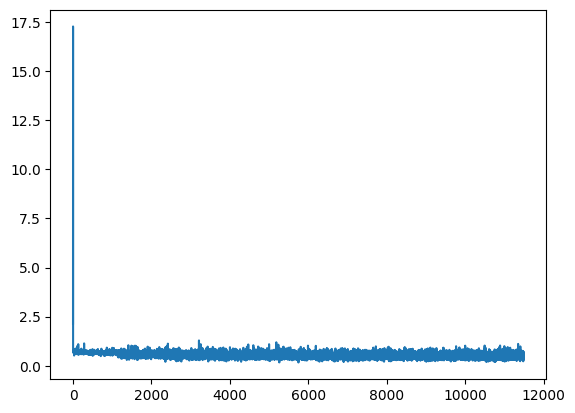

In [40]:
plt.plot(loss_tracker)

In [41]:

# Evaluate the model on test data
with torch.no_grad():
    for i, (test_data, test_labels) in enumerate(test_loader):
        outputs = model(test_data[0], test_data[1])
        predicted = (outputs > 0.5).float()
        accuracy = (predicted == test_labels).float().mean()
        print('Test Accuracy: {:.2f}%'.format(accuracy * 100))


Test Accuracy: 51.59%


In [ ]:
model = Model()
model.to(device)

loss_fn = nn.CrossEntropyLoss(reduction='sum')

optimizer1 = optim.Adam(model.parameters())
optimizer2 = optim.SGD(model.parameters(), lr=0.001)

n_epochs = 3
optimizer_cutoff = int(n_epochs*4/4.0)

NameError: name 'input_size' is not defined

In [34]:
tic = time.time()
print(f'Setup Time: {tic - ts}')
te = tic

for epoch in range(n_epochs):
    train_loss = 0
    test_loss = 0
    if epoch < optimizer_cutoff:
        optimizer = optimizer1
    else:
        optimizer = optimizer2
    for ex in train_loader:
        inputs, labs = ex
        inputs = inputs.to(device)
        labs = labs.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs).to(device)
        loss = loss_fn(outputs, labs)
        train_loss += loss / train_test[0].shape[0]
        loss.backward()
        optimizer.step()

    acc = 0
    with torch.no_grad():
        for ex in test_loader:
            inputs, labs = ex
            inputs = inputs.to(device)
            labs = labs.to(device)
            outputs = model(inputs).to(device)
            test_loss += loss_fn(outputs, labs) / train_test[1].shape[0]
            ps, preds = torch.max(outputs)
            acc += sum(preds == labs) / train_test[1].shape[0]
    print(f'Epoch {epoch+1} Accuracy: {acc*100},\tTrain Loss: {train_loss},', end='')
    print(f'\tTest Loss: {test_loss},\tRuntime: {time.time()-te}')
    te = time.time()
    
toc = time.time()
print(f'Training Runtime: {toc-tic}s')

Setup Time: 44827.66735339165


NameError: name 'n_epochs' is not defined